In [355]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import all required libraries and modules

In [356]:
import os 
import sys
from scipy.stats import shapiro, norm, mannwhitneyu
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

sys.path.append("/Users/nikolaynechay/Iris-Species")

In [375]:
from src.core.helpers.model_evaluation import evaluate_model
from src.core.helpers.error_analysis import analyse_logits_in_incorrect_predictions, error_analysis, calculate_main_statistics
from src.core.helpers.ea_hist_by_target import plot_error_distribution
from src.core.helpers.visualizations import plot_distribution_of_logits
from src.core.helpers.confusion_matrix_for_missclassifications import plot_confusion_matrix_for_miss_classifications

In [358]:
os.chdir("/Users/nikolaynechay/Iris-Species")

# Data Collection

### Setting required Global Variables

In [359]:
IRIS_PATH="src/core/datafiles/raw/Iris.csv"

### Load dataset

In [360]:
iris_df = pd.read_csv(IRIS_PATH)
iris_df.drop('Id', axis=1, inplace=True)  # Delete ID column
display(iris_df.head().style.background_gradient(cmap='Greys'))

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.100000,3.500000,1.400000,0.200000,Iris-setosa
1,4.900000,3.000000,1.400000,0.200000,Iris-setosa
2,4.700000,3.200000,1.300000,0.200000,Iris-setosa
3,4.600000,3.100000,1.500000,0.200000,Iris-setosa
4,5.000000,3.600000,1.400000,0.200000,Iris-setosa


# Model building

In [361]:
# Split data into train and test sets
X, y = iris_df.drop('Species', axis=1), iris_df['Species']
X_train, X_test, y_train, y_test = train_test_split(
    X,y,
    test_size=0.2,
    random_state=41,
    stratify=y
)

In [362]:
# build baseline logistic regression model
baseline_logistic_regression_model = LogisticRegression(max_iter=50, random_state=42)
baseline_logistic_regression_model.fit(X_train, y_train)

baseline_train_df_with_predictions, baseline_train_accuracy, baseline_train_precision, baseline_train_recall, baseline_train_f1 = evaluate_model(X_train, y_train, baseline_logistic_regression_model)
baseline_test_df_with_predictions, baseline_test_accuracy, baseline_test_precision, baseline_test_recall, baseline_test_f1 = evaluate_model(X_test, y_test, baseline_logistic_regression_model)

/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [363]:
# build working logistic regression model
working_model = LogisticRegression(max_iter=50, random_state=41)
working_model.fit(X_train, y_train)

train_df_with_predictions, train_accuracy, train_precision, train_recall, train_f1 = evaluate_model(X_train, y_train, working_model)
test_df_with_predictions, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(X_test, y_test, working_model)

print("Working model evaluation:")
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Train Precision: {train_precision:.4f}")
print(f"Train Recall: {train_recall:.4f}")
print(f"Train F1: {train_f1:.4f}")
print('---------------------')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")

Working model evaluation:
Train Accuracy: 0.9750
Train Precision: 0.9752
Train Recall: 0.9750
Train F1: 0.9750
---------------------
Test Accuracy: 0.9333
Test Precision: 0.9333
Test Recall: 0.9333
Test F1: 0.9333


/Users/nikolaynechay/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [364]:
train_df_with_predictions.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_Iris-setosa,probability_of_Iris-versicolor,probability_of_Iris-virginica,is_correct
123,6.3,2.7,4.9,1.8,Iris-virginica,Iris-virginica,0.002,0.454,0.544,True
106,4.9,2.5,4.5,1.7,Iris-virginica,Iris-versicolor,0.004,0.562,0.434,False
149,5.9,3.0,5.1,1.8,Iris-virginica,Iris-virginica,0.001,0.250,0.749,True
10,5.4,3.7,1.5,0.2,Iris-setosa,Iris-setosa,0.976,0.024,0.000,True
98,5.1,2.5,3.0,1.1,Iris-versicolor,Iris-versicolor,0.203,0.796,0.002,True


# ER (Error Analysis)



##### Distribution of correct and incorrect predictions on train set

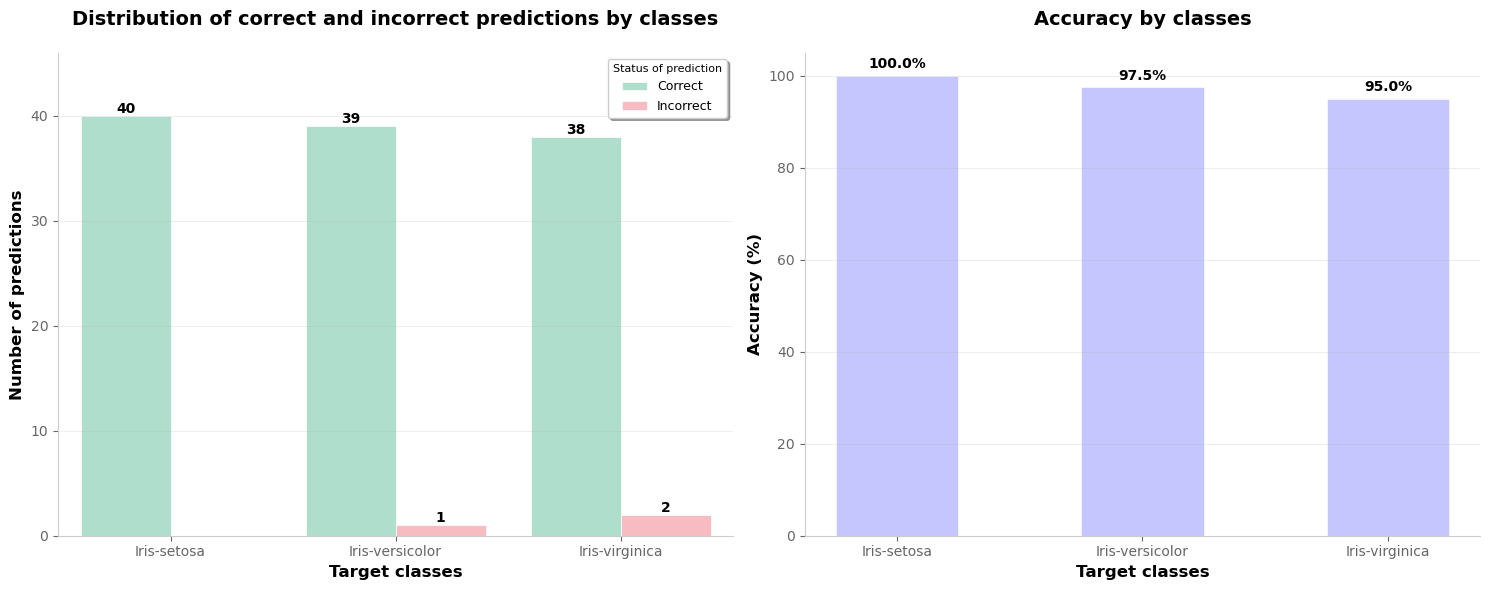

In [365]:
plot_error_distribution(train_df_with_predictions['predicted_label'], y_train)


##### Distribution of correct and incorrect predictions on test set

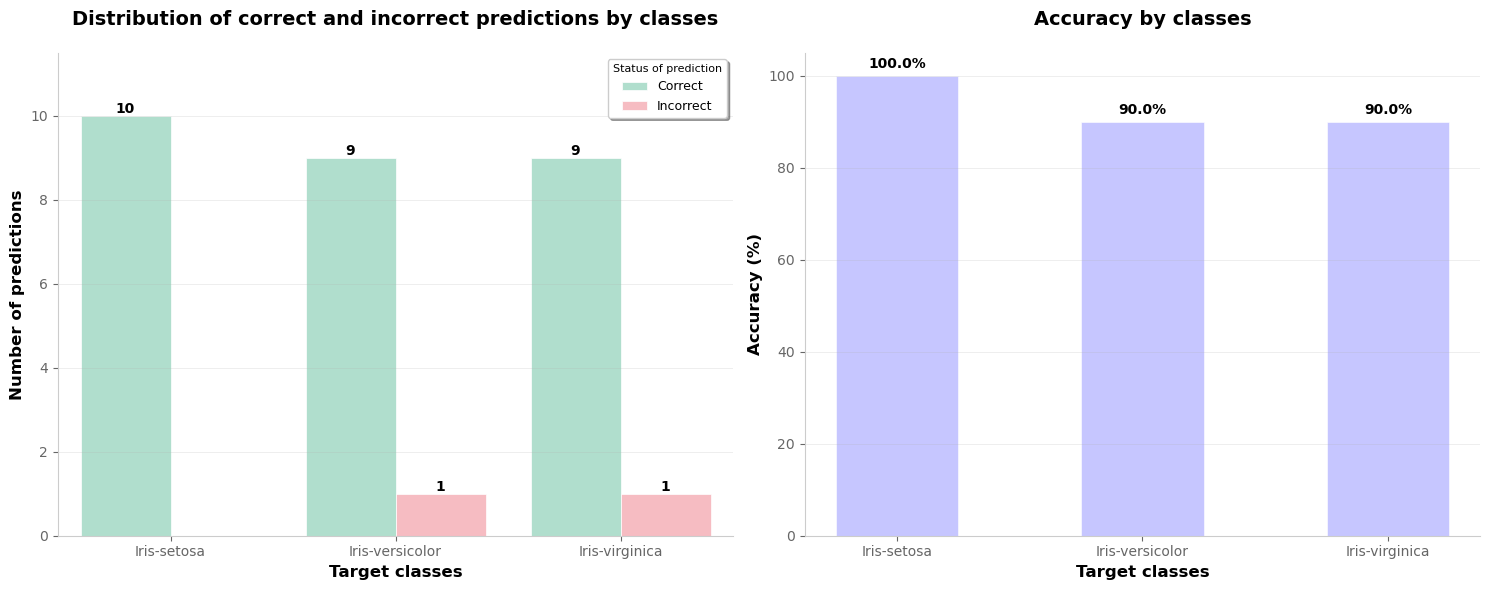

In [366]:
plot_error_distribution(test_df_with_predictions['predicted_label'], y_test)

##### Create dataframe for error classifications on train set

In [367]:
train_df_errors = train_df_with_predictions[train_df_with_predictions['is_correct'] == False]
train_df_errors.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_Iris-setosa,probability_of_Iris-versicolor,probability_of_Iris-virginica,is_correct
106,4.9,2.5,4.5,1.7,Iris-virginica,Iris-versicolor,0.004,0.562,0.434,False
83,6.0,2.7,5.1,1.6,Iris-versicolor,Iris-virginica,0.001,0.420,0.579,False
119,6.0,2.2,5.0,1.5,Iris-virginica,Iris-versicolor,0.001,0.600,0.399,False


##### Create dataframe for error classifications on test set

In [368]:
test_df_errors = test_df_with_predictions[test_df_with_predictions['is_correct'] == False]
test_df_errors.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,true_label,predicted_label,probability_of_Iris-setosa,probability_of_Iris-versicolor,probability_of_Iris-virginica,is_correct
70,5.9,3.2,4.8,1.8,Iris-versicolor,Iris-virginica,0.004,0.412,0.584,False
133,6.3,2.8,5.1,1.5,Iris-virginica,Iris-versicolor,0.001,0.542,0.456,False


##### Plot confusion matrix for miss classifications on train set

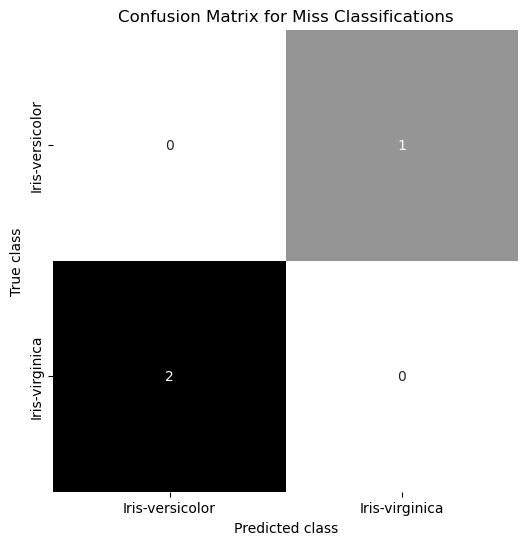

In [369]:
plot_confusion_matrix_for_miss_classifications(train_df_errors)

##### Plot confusion matrix for miss classifications on test set

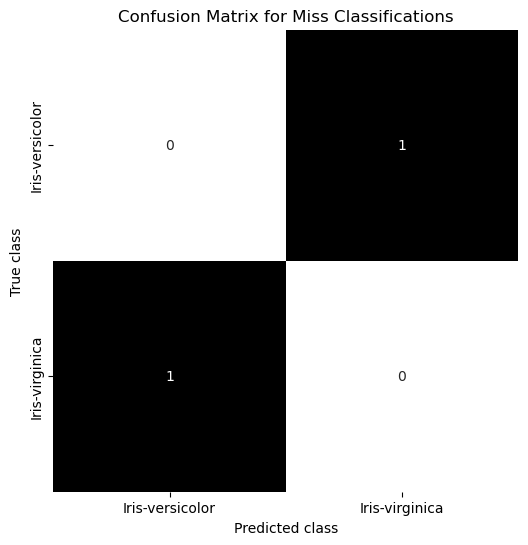

In [370]:
plot_confusion_matrix_for_miss_classifications(test_df_errors)

In [371]:
weights = working_model.coef_[0]
bias = working_model.intercept_[0]
feature_names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']

print(f"Weights: {weights}\nBias: {bias}")

Weights: [ 0.21367371  0.77728805 -2.45584691 -1.01756082]
Bias: 6.632422773115125


In [372]:
detailed_df = error_analysis(train_df_with_predictions, weights, bias, feature_names)
detailed_df.head()

,original_idx,true_label,predicted_label,logit,probability,SepalLengthCm_value,SepalLengthCm_contribution,SepalLengthCm_weight,SepalWidthCm_value,SepalWidthCm_contribution,SepalWidthCm_weight,PetalLengthCm_value,PetalLengthCm_contribution,PetalLengthCm_weight,PetalWidthCm_value,PetalWidthCm_contribution,PetalWidthCm_weight,bias
0,123,Iris-virginica,Iris-virginica,-3.788014,0.022139,6.3,1.346144,0.213674,2.7,2.098678,0.777288,4.9,-12.033650,-2.455847,1.8,-1.831609,-1.017561,6.632423
1,106,Iris-virginica,Iris-versicolor,-3.158520,0.040757,4.9,1.047001,0.213674,2.5,1.943220,0.777288,4.5,-11.051311,-2.455847,1.7,-1.729853,-1.017561,6.632423
2,149,Iris-virginica,Iris-virginica,-4.131467,0.015805,5.9,1.260675,0.213674,3.0,2.331864,0.777288,5.1,-12.524819,-2.455847,1.8,-1.831609,-1.017561,6.632423
3,10,Iris-setosa,Iris-setosa,6.774944,0.998859,5.4,1.153838,0.213674,3.7,2.875966,0.777288,1.5,-3.683770,-2.455847,0.2,-0.203512,-1.017561,6.632423
4,98,Iris-versicolor,Iris-versicolor,1.178521,0.764682,5.1,1.089736,0.213674,2.5,1.943220,0.777288,3.0,-7.367541,-2.455847,1.1,-1.119317,-1.017561,6.632423


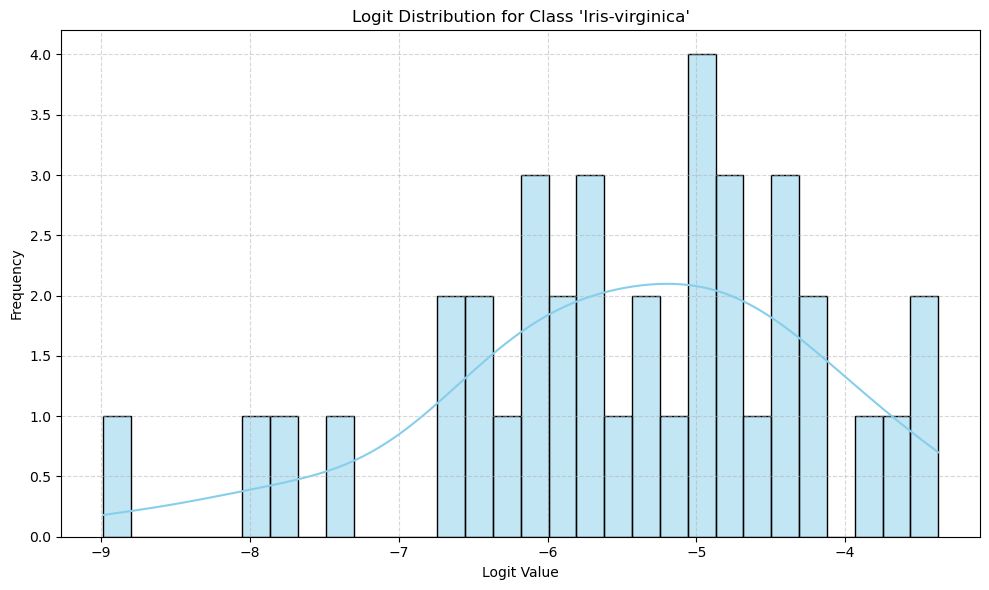


Analyzing sample 1 with respect to TRUE class: 'Iris-virginica'
Shapiro–Wilk test PASSED (p = 0.2957) → Logit dist is normal.
[Z-test] Logit = -3.159, z = 1.82, p = 0.0686 → Within expected range.

Analyzing sample 10 with respect to PREDICTED class: 'Iris-virginica'
Shapiro–Wilk test PASSED (p = 0.2957) → Logit dist is normal.
[Z-test] Logit = -4.140, z = 1.05, p = 0.2935 → Within expected range.

Analyzing sample 113 with respect to TRUE class: 'Iris-virginica'
Shapiro–Wilk test PASSED (p = 0.2957) → Logit dist is normal.
[Z-test] Logit = -4.181, z = 1.02, p = 0.3087 → Within expected range.


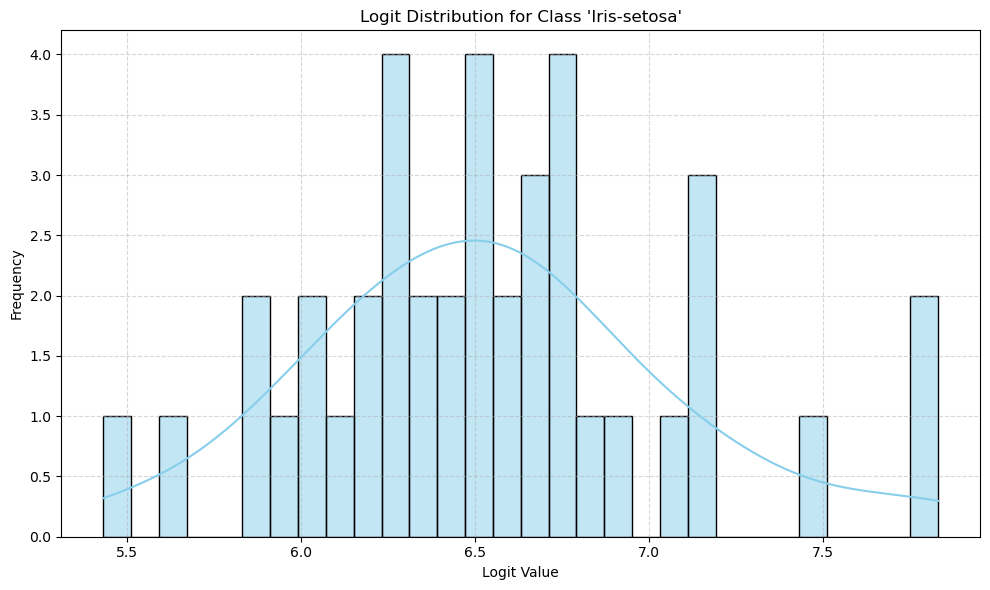

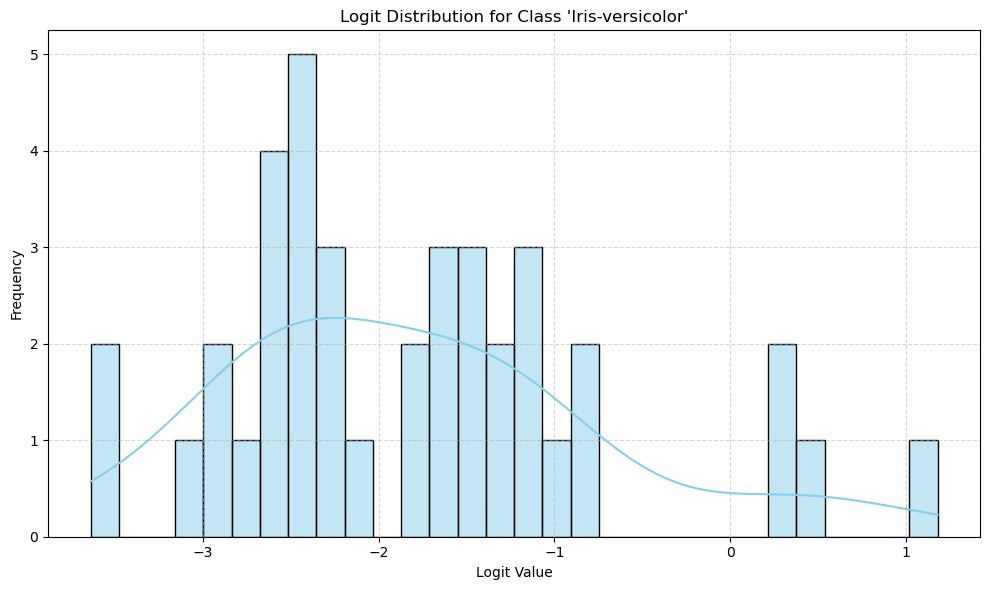


Analyzing sample 1 with respect to PREDICTED class: 'Iris-versicolor'
Shapiro–Wilk test FAILED (p = 0.0458) → Non-normal distribution.
[Mann–Whitney] p = 0.1500 → Consistent with predicted class distribution.

Analyzing sample 10 with respect to TRUE class: 'Iris-versicolor'
Shapiro–Wilk test FAILED (p = 0.0458) → Non-normal distribution.
[Mann–Whitney] p = 0.0500 → Consistent with correct distribution.

Analyzing sample 113 with respect to PREDICTED class: 'Iris-versicolor'
Shapiro–Wilk test FAILED (p = 0.0458) → Non-normal distribution.
[Mann–Whitney] p = 0.0500 → Consistent with predicted class distribution.


In [373]:
analyse_logits_in_incorrect_predictions(
    df=detailed_df,
    classes=detailed_df['true_label'].unique()
)

In [381]:
def analyse_contributions_in_incorrect_predictions(
    df: pd.DataFrame,
    classes: list,
    feature_names: list,
    alpha: float = 0.05
) -> None:
    """Define the most impactful features in incorrect predictions."""
    contribution_cols = [col for col in df.columns if col.endswith("_contribution")]
    df['is_correct'] = df['true_label'] == df['predicted_label']
    
    for class_name in classes:
        correct_classified_df = df[(df['is_correct'] == True) & (df['true_label'] == class_name)]
        incorrect_classified_df = df[(df['is_correct'] == False)]
    
        contribution_statistics = calculate_main_statistics(correct_df=correct_classified_df, columns=contribution_cols)
        features_statistics = calculate_main_statistics(correct_classified_df, columns=[str(x)+"_value" for x in feature_names])
        for i, row in incorrect_classified_df.iterrows():
            if row['true_label'] == class_name and len(correct_classified_df) > 30:
                print(f"\nAnalyzing sample {i} with respect to TRUE class: '{class_name}'")
                for feature in feature_names:
                    stat, p_value = shapiro(correct_classified_df[str(feature)+'_value'])
                    print(f"Analysing feature: {feature}")
                    if p_value >= alpha:
                        print(f"Shapiro–Wilk test PASSED (p = {p_value:.4f}) → Feature distribution is normal.")
                        z_score = (row[str(feature)+'_value'] - features_statistics[str(feature)+'_value']['mean']) / features_statistics[str(feature)+'_value']['std']
                        p = 2 * (1 - norm.cdf(abs(z_score)))
                        if p >= alpha:
                            print(f"[Z-test] Feature = {row[str(feature)+'_value']:.3f}, z = {z_score:.2f}, p = {p:.4f} → Within expected range.")
                        else:
                            print(f"[Z-test] Feature = {row[str(feature)+'_value']:.3f}, z = {z_score:.2f}, p = {p:.4f} → Statistically different (reject H₀).")
                    else:
                        print(f"Shapiro–Wilk test FAILED (p = {p_value:.4f}) → Non-normal distribution.")
                        _, p = mannwhitneyu(correct_classified_df[str(feature)+"_value"], [row[str(feature)+'_value']], alternative='two-sided')
                        if p >= alpha:
                            print(f"[Mann–Whitney] p = {p:.4f} → Consistent with correct distribution.")
                        else:
                            print(f"[Mann–Whitney] p = {p:.4f} → Logit is anomalous in TRUE class.")
                for contribution in contribution_cols:
                    stat, p_value = shapiro(correct_classified_df[contribution])
                    print(f"Analysing contribution: {contribution}")
                    if p_value >= alpha:
                        print(f"Shapiro–Wilk test PASSED (p = {p_value:.4f}) → Contribution member distribution is normal.")
                        z_score = (row[contribution] - contribution_statistics[contribution]['mean']) / contribution_statistics[contribution]['std']
                        p = 2 * (1 - norm.cdf(abs(z_score)))
                        if p >= alpha:
                            print(f"[Z-test] Contribution member = {row[contribution]:.3f}, z = {z_score:.2f}, p = {p:.4f} → Within expected range.")
                        else:
                            print(f"[Z-test] Contribution membe = {row[contribution]:.3f}, z = {z_score:.2f}, p = {p:.4f} → Statistically different (reject H₀).")
                    else:
                        print(f"Shapiro–Wilk test FAILED (p = {p_value:.4f}) → Non-normal distribution.")
                        _, p = mannwhitneyu(correct_classified_df[contribution], [row[contribution]], alternative='two-sided')
                        if p >= alpha:
                            print(f"[Mann–Whitney] p = {p:.4f} → Consistent with correct distribution.")
                        else:
                            print(f"[Mann–Whitney] p = {p:.4f} → Logit is anomalous in TRUE class.")
            elif row['predicted_label'] == class_name and len(correct_classified_df) > 30:
                print(f"\nAnalyzing sample {i} with respect to PREDICTED class: '{class_name}'")
                for feature in feature_names:
                    stat, p_value = shapiro(correct_classified_df[str(feature)+'_value'])
                    print(f"Analysing feature: {feature}")
                    if p_value >= alpha:
                        print(f"Shapiro–Wilk test PASSED (p = {p_value:.4f}) → Feature distribution is normal.")
                        z_score = (row[str(feature)+'_value'] - features_statistics[str(feature)+'_value']['mean']) / features_statistics[str(feature)+'_value']['std']
                        p = 2 * (1 - norm.cdf(abs(z_score)))
                        if p >= alpha:
                            print(f"[Z-test] Feature = {row[str(feature)+'_value']:.3f}, z = {z_score:.2f}, p = {p:.4f} → Within expected range.")
                        else:
                            print(f"[Z-test] Feature = {row[str(feature)+'_value']:.3f}, z = {z_score:.2f}, p = {p:.4f} → Statistically different (reject H₀).")
                    else:
                        print(f"Shapiro–Wilk test FAILED (p = {p_value:.4f}) → Non-normal distribution.")
                        _, p = mannwhitneyu(correct_classified_df[str(feature)+"_value"], [row[str(feature)+'_value']], alternative='two-sided')
                        if p >= alpha:
                            print(f"[Mann–Whitney] p = {p:.4f} → Consistent with predicted class distribution.")
                        else:
                            print(f"[Mann–Whitney] p = {p:.4f} → Logit is anomalous in PREDICTED class.")
                for contribution in contribution_cols:
                    stat, p_value = shapiro(correct_classified_df[contribution])
                    print(f"Analysing contribution: {contribution}")
                    if p_value >= alpha:
                        print(f"Shapiro–Wilk test PASSED (p = {p_value:.4f}) → Contribution member distribution is normal.")
                        z_score = (row[contribution] - contribution_statistics[contribution]['mean']) / contribution_statistics[contribution]['std']
                        p = 2 * (1 - norm.cdf(abs(z_score)))
                        if p >= alpha:
                            print(f"[Z-test] Contribution member = {row[contribution]:.3f}, z = {z_score:.2f}, p = {p:.4f} → Within expected range.")
                        else:
                            print(f"[Z-test] Contribution membe = {row[contribution]:.3f}, z = {z_score:.2f}, p = {p:.4f} → Statistically different (reject H₀).")
                    else:
                        print(f"Shapiro–Wilk test FAILED (p = {p_value:.4f}) → Non-normal distribution.")
                        _, p = mannwhitneyu(correct_classified_df[contribution], [row[contribution]], alternative='two-sided')
                        if p >= alpha:
                            print(f"[Mann–Whitney] p = {p:.4f} → Consistent with predicted class distribution.")
                        else:
                            print(f"[Mann–Whitney] p = {p:.4f} → Logit is anomalous in PREDICTED class.")
                    
                    

        
analyse_contributions_in_incorrect_predictions(
    df=detailed_df,
    classes=detailed_df['true_label'].unique(),
    feature_names=feature_names
)


Analyzing sample 1 with respect to TRUE class: 'Iris-virginica'
Analysing feature: SepalLengthCm
Shapiro–Wilk test PASSED (p = 0.0955) → Feature distribution is normal.
[Z-test] Feature = 4.900, z = -3.02, p = 0.0025 → Statistically different (reject H₀).
Analysing feature: SepalWidthCm
Shapiro–Wilk test FAILED (p = 0.0213) → Non-normal distribution.
[Mann–Whitney] p = 0.1253 → Consistent with correct distribution.
Analysing feature: PetalLengthCm
Shapiro–Wilk test PASSED (p = 0.0608) → Feature distribution is normal.
[Z-test] Feature = 4.500, z = -1.99, p = 0.0471 → Statistically different (reject H₀).
Analysing feature: PetalWidthCm
Shapiro–Wilk test PASSED (p = 0.0534) → Feature distribution is normal.
[Z-test] Feature = 1.700, z = -1.63, p = 0.1034 → Within expected range.
Analysing contribution: SepalLengthCm_contribution
Shapiro–Wilk test PASSED (p = 0.0955) → Contribution member distribution is normal.
[Z-test] Contribution membe = 1.047, z = -3.02, p = 0.0025 → Statistically d

### Error Analysis on Training Set

During the analysis, it was found that the total number of misclassified samples is 3. Of these, 2 samples were predicted as Iris-versicolor, and 1 sample as Iris-virginica.

Step 1: Statistical Analysis of Logits

The goal of this step was to verify whether the logit values of the misclassified samples are statistically significantly different from the distribution of logits in correctly classified samples. The comparison was made with respect to:

	•	the distribution of logits for correctly classified samples with the same true class;
	•	the distribution of logits for correctly classified samples with the same predicted class.

Analysis procedure:

	1.	Test for normality of logit values using the Shapiro–Wilk test.
	2.	Based on the result:
		- If normal distribution → apply z-test
		- If non-normal distribution → apply Mann–Whitney U test

Results by Sample

Sample #1

	•	True class: Iris-virginica
	•	Logits distribution: normal (Shapiro–Wilk p = 0.2957)
	•	Z-test: p = 0.0686 → logit is not significantly different
	•	Predicted class: Iris-versicolor
	•	Logits distribution: non-normal (Shapiro–Wilk p = 0.0458)
	•	Mann–Whitney: p = 0.1500 → logit is consistent with the predicted distribution

Conclusion: The logit is closer to the distribution of the predicted class, suggesting that the input features may be pulling the sample toward Iris-versicolor. Further feature contribution analysis is recommended.

Sample #10

	•	True class: Iris-versicolor
	•	Logits distribution: non-normal (Shapiro–Wilk p = 0.0458)
	•	Mann–Whitney: p = 0.0500 → borderline acceptable
	•	Predicted class: Iris-virginica
	•	Logits distribution: normal (Shapiro–Wilk p = 0.2957)
	•	Z-test: p = 0.2935 → logit is not significantly different

Conclusion: The logit is again closer to the predicted class distribution. This indicates that the features may align more closely with Iris-virginica. The sample should be examined in more detail.

Sample #113

	•	True class: Iris-virginica
	•	Logits distribution: normal (Shapiro–Wilk p = 0.2957)
	•	Z-test: p = 0.3087 → logit is not significantly different
	•	Predicted class: Iris-versicolor
	•	Logits distribution: non-normal (Shapiro–Wilk p = 0.0458)
	•	Mann–Whitney: p = 0.0500 → borderline acceptable

Conclusion: Although this sample was misclassified, the logit is very close to the target class distribution. This could indicate a borderline or ambiguous case and is worth deeper investigation.